In [1]:
import os
import xrft
import numpy as np
import torch
from tqdm import tqdm
from dataset import Agulhas, Agulhas3
from models.Pix2Pix import Generator
from models.Dhruv import initialize_weights, DnCNN
from utils import load_checkpoint, plot_examples, qqplot
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import xarray as xr
import matplotlib.pyplot as plt

%load_ext autoreload

In [2]:
MODEL = 'DnCNN'
LEARNING_RATE = 2.0E-4
RESTORE_FROM = os.path.join('outputs', MODEL, 'T05', 'epoch-100')

In [3]:
with open( os.path.join(RESTORE_FROM, 'loss.npy'), 'rb') as f:
    data = np.load(f)

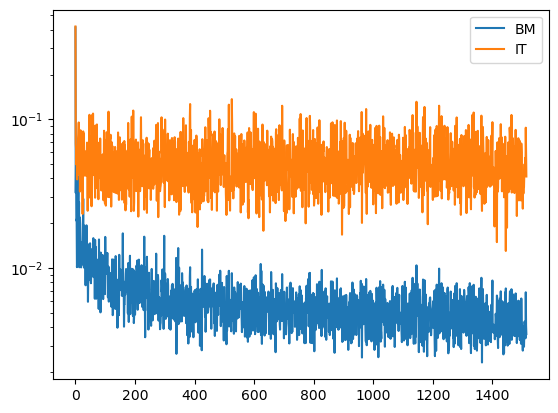

In [9]:
fig, ax = plt.subplots()
ax.semilogy(data[:, 0], label='BM')
ax.semilogy(data[:, 1], label='IT')

plt.legend()
plt.show()

In [3]:
dataset = Agulhas3(split='val', joint_transform=None)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=False, drop_last=False)

# trans_params = dict()
# trans_params['inputs_mean'] = dataset.inputs_mean_std[0]
# trans_params['inputs_std'] = dataset.inputs_mean_std[1]
# trans_params['targets_mean'] = dataset.targets_mean_std[0]
# trans_params['targets_std'] = dataset.targets_mean_std[1]

In [4]:
cudnn.enabled = True
cudnn.benchmark = True

model = DnCNN(in_channels=1, num_features=64).cuda()

In [ ]:
load_checkpoint(f'{RESTORE_FROM}/model.pth.tar', model, None, None)

In [7]:
data_iter = iter(dataloader)
ssh, it, bm = next(data_iter)

initialize_weights(model)

with torch.no_grad():
    
    ssh = ssh.cuda()
    bm_, it_ = model(ssh)
    
    inp = (ssh.detach().cpu().numpy() + 1) / 2
    tar = (bm_.detach().cpu().numpy() + 1) / 2
    gen = (it_.detach().cpu().numpy() + 1) / 2

    inp = inp * (dataset.transform_dict['inputs'][1] - dataset.transform_dict['inputs'][0]) + dataset.transform_dict['inputs'][0]
    tar = tar * (dataset.transform_dict['targets_bm'][1] - dataset.transform_dict['targets_bm'][0]) + dataset.transform_dict['targets_bm'][0]
    gen = gen * (dataset.transform_dict['targets_bm'][1] - dataset.transform_dict['targets_bm'][0]) + dataset.transform_dict['targets_bm'][0]

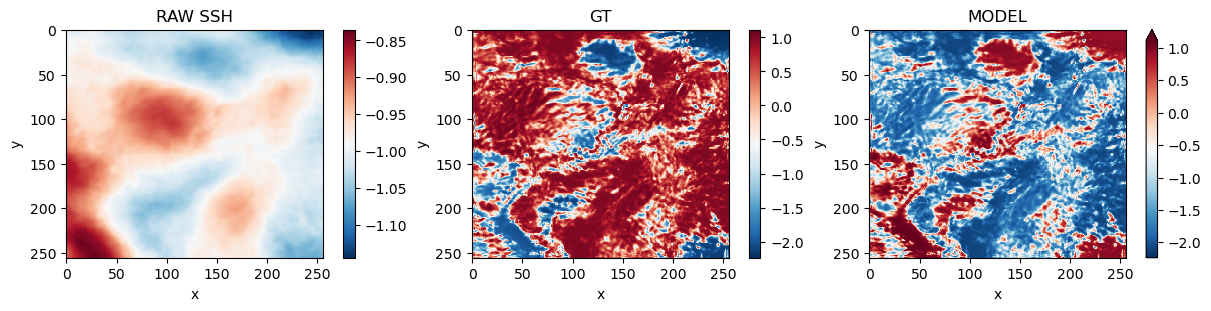

In [8]:
plot_examples(inp, inp-tar, inp-gen)

In [12]:
model.eval()
inps = np.empty((0, 1, 256, 256))
tars = np.empty((0, 1, 256, 256))
gens = np.empty((0, 1, 256, 256))

with torch.no_grad():
    
    loop = tqdm(dataloader, leave=True)
    for counter, (x, _, y) in enumerate(loop, 1):

        # GPU deployment
        x = x.cuda()
        y = y.cuda()

        # Compute prediction and loss
        g = model(x)
        
        # inps = np.concatenate((inps, x.detach().cpu().numpy() * trans_params['inputs_std'] + trans_params['inputs_mean']), axis=0)
        # tars = np.concatenate((tars, y.detach().cpu().numpy() * trans_params['targets_std'] + trans_params['targets_mean']), axis=0)
        # gens = np.concatenate((gens, g.detach().cpu().numpy() * trans_params['targets_std'] + trans_params['targets_mean']) , axis=0)
        
        inp = (x.detach().cpu().numpy() + 1) / 2
        tar = (y.detach().cpu().numpy() + 1) / 2
        gen = (g.detach().cpu().numpy() + 1) / 2
        
        inps = np.concatenate((inps, inp * (dataset.transform_dict['inputs'][1] - dataset.transform_dict['inputs'][0]) + dataset.transform_dict['inputs'][0]), axis=0)
        tars = np.concatenate((tars, tar * (dataset.transform_dict['targets_bm'][1] - dataset.transform_dict['targets_bm'][0]) + dataset.transform_dict['targets_bm'][0]), axis=0)
        gens = np.concatenate((gens, gen * (dataset.transform_dict['targets_bm'][1] - dataset.transform_dict['targets_bm'][0]) + dataset.transform_dict['targets_bm'][0]) , axis=0)

print(inps.shape, tars.shape, gens.shape)   

100%|██████████| 413/413 [01:15<00:00,  5.48it/s]

(413, 1, 256, 256) (413, 1, 256, 256) (413, 1, 256, 256)


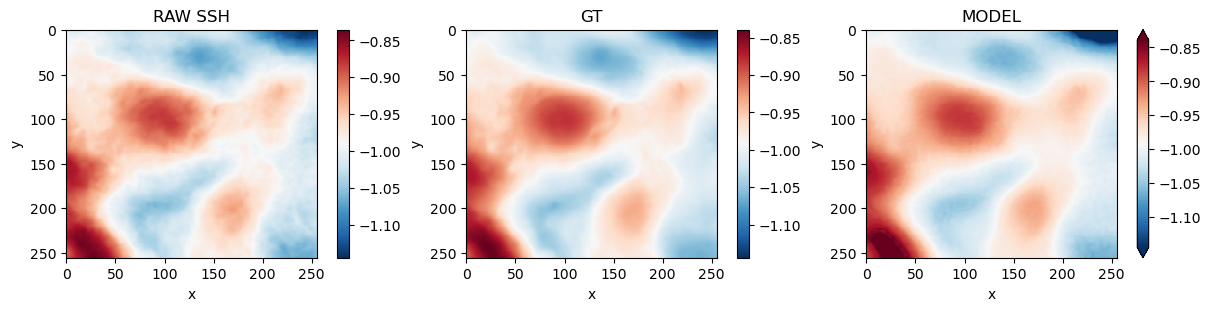

In [18]:
idx = 0
plot_examples(inps[idx], tars[idx], gens[idx])

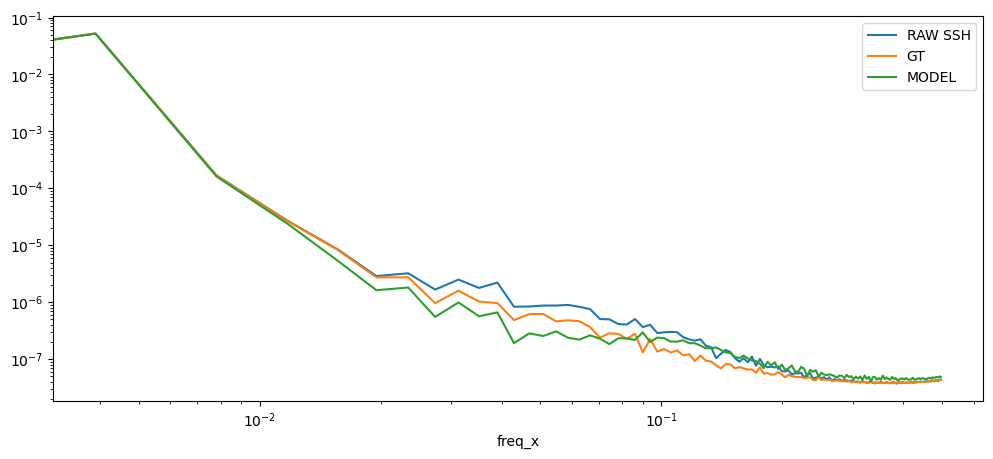

In [19]:
fig, ax = plt.subplots(figsize=(12, 5))

da_raw = xr.DataArray(inps[idx].squeeze(), dims=['x', 'y'])
da_itr = xr.DataArray(tars[idx].squeeze(), dims=['x', 'y'])
da_itg = xr.DataArray(gens[idx].squeeze(), dims=['x', 'y'])

ps_raw = xrft.power_spectrum(da_raw, 'x', window='hamming').rename('raw')
ps_itr = xrft.power_spectrum(da_itr, 'x', window='hamming').rename('raw')
ps_itg = xrft.power_spectrum(da_itg, 'x', window='hamming').rename('raw')

(ps_raw * ps_raw.freq_x).mean('y').plot(label='RAW SSH', ax=ax)
(ps_itr * ps_itr.freq_x).mean('y').plot(label='GT', ax=ax)
(ps_itg * ps_itg.freq_x).mean('y').plot(label='MODEL', ax=ax)

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(tars[idx].ravel(), gens[idx].ravel(), squared=False)
print(mse)

0.014356499117029147


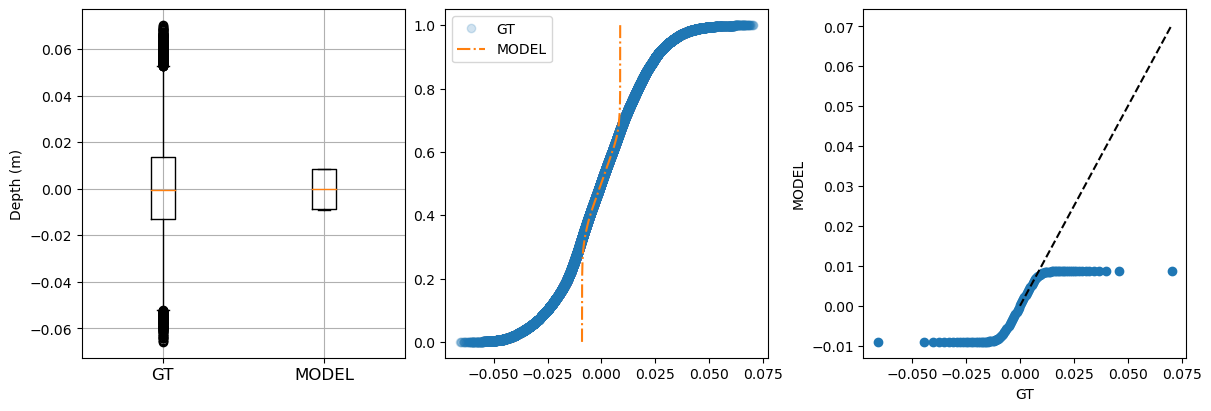

In [10]:
qqplot(tars[idx].ravel(), gens[idx].ravel(), quantiles=100)

In [20]:
# Generating ITs
model.eval()
its_inp = np.empty((0, 1, 256, 256))
its_gen = np.empty((0, 1, 256, 256))


with torch.no_grad():
    
    loop = tqdm(dataloader, leave=True)
    for counter, (_, y) in enumerate(loop, 1):

        # GPU deployment
        y = y.cuda()

        # Compute prediction and loss
        g = model(y)
        
        its_inp = np.concatenate((its_inp, y.detach().cpu().numpy() * trans_params['targets_std'] + trans_params['targets_mean']), axis=0)
        its_gen = np.concatenate((its_gen, g.detach().cpu().numpy() * trans_params['targets_std'] + trans_params['targets_mean']) , axis=0)

100%|██████████| 413/413 [00:38<00:00, 10.69it/s]


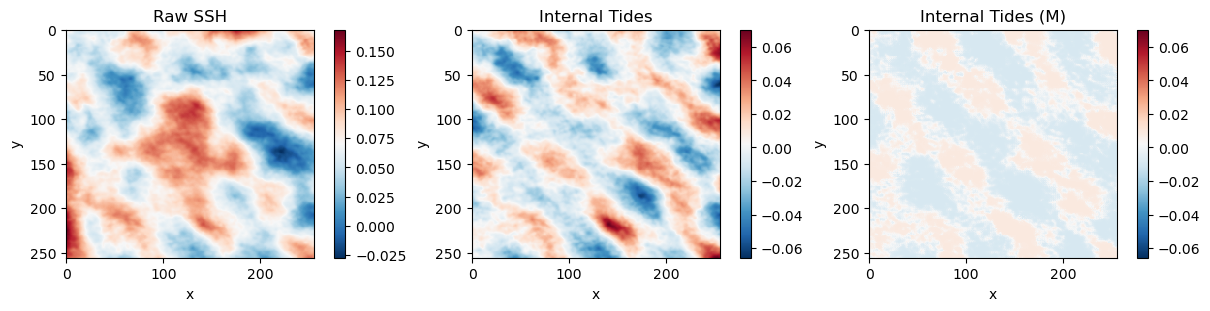

In [30]:
idx = 15
plot_examples(inps[idx], its_inp[idx], its_gen[idx])

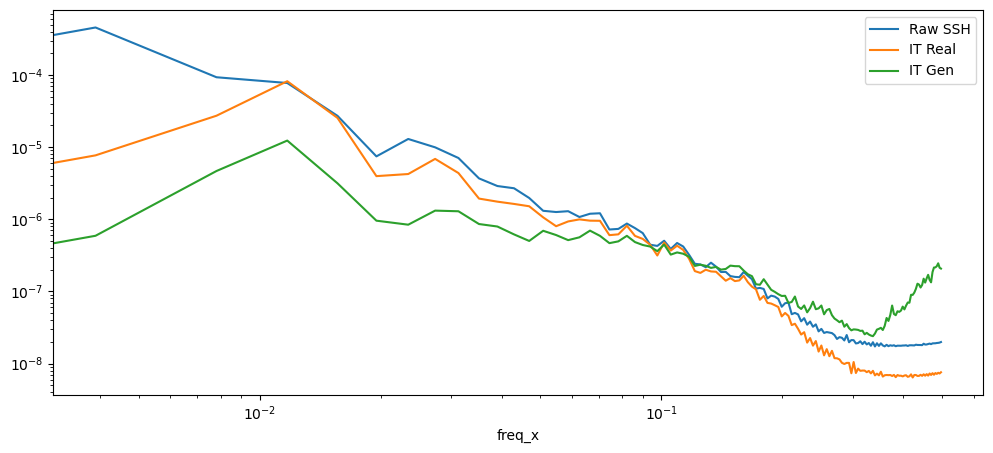

In [31]:
import xarray as xr
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 5))

da_raw = xr.DataArray(inps[idx].squeeze(), dims=['x', 'y'])
da_itr = xr.DataArray(its_inp[idx].squeeze(), dims=['x', 'y'])
da_itg = xr.DataArray(its_gen[idx].squeeze(), dims=['x', 'y'])

ps_raw = xrft.power_spectrum(da_raw, 'x', window='hamming').rename('raw')
ps_itr = xrft.power_spectrum(da_itr, 'x', window='hamming').rename('raw')
ps_itg = xrft.power_spectrum(da_itg, 'x', window='hamming').rename('raw')

(ps_raw * ps_raw.freq_x).mean('y').plot(label='Raw SSH', ax=ax)
(ps_itr * ps_itr.freq_x).mean('y').plot(label='IT Real', ax=ax)
(ps_itg * ps_itg.freq_x).mean('y').plot(label='IT Gen', ax=ax)

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.show()